In [3]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 594 ms, sys: 260 ms, total: 854 ms
Wall time: 1.86 s


In [4]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 6.29 s, sys: 1.01 s, total: 7.29 s
Wall time: 9.5 s


In [5]:
class WideDeep(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(WideDeep, self).__init__()
        
        self.wide = FeaturesEmbedding(field_dims, 1)
        
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.deep = MultiLayerPerceptron([embed_dim * len(field_dims), 128, 64, 32])
        self.fc = nn.Linear(32 + embed_dim * len(field_dims), 1)
        
    def forward(self, x):
        # x shape: (batch_size, num_fields)
        wide_output = self.wide(x)
        embedding_output = self.embedding(x).reshape(x.shape[0], -1)
        deep_output = self.deep(embedding_output)
        concat = torch.hstack([embedding_output, deep_output])
        output = self.fc(concat)
        output = torch.sigmoid(output)
        
        return output


 17%|█▋        | 103/600 [00:14<01:07,  7.32it/s]


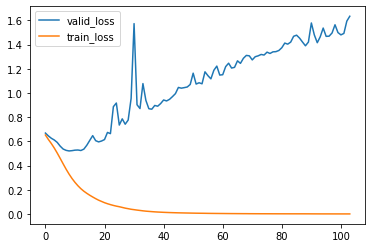

train_loss: 0.59628 | train_metric: 0.92153
valid_loss: 0.61179 | valid_metric: 0.74230
test_loss:  0.60896 | test_auc:  0.75216
CPU times: user 13.6 s, sys: 203 ms, total: 13.8 s
Wall time: 14.4 s


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

wd = WideDeep(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(wd.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(wd, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
